In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from darts import TimeSeries

df = pd.read_csv('../csv/Ming1Jul67_total_order.csv')
df.tail()

,order_completed_at,unique_order_count
543,2024-06-27,145
544,2024-06-28,142
545,2024-06-29,126
546,2024-06-30,161
547,2024-07-01,142


In [3]:
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])
# make timeseries Object
series = TimeSeries.from_dataframe(df,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")

In [4]:
# Function to replace outliers with the mean of the rest of the values
from scipy.stats import zscore
from darts import TimeSeries

def replace_outliers_with_mean(df, column_name):
    # Calculate Z-scores
    z_scores = zscore(df[column_name])
    
    # Identify outliers (using a threshold of 3 for Z-score)
    outliers = np.abs(z_scores) > 3
    
    # Calculate mean of non-outliers
    mean_non_outliers = df.loc[~outliers, column_name].mean()
    
    # Replace outliers with the mean of non-outliers
    df.loc[outliers, column_name] = mean_non_outliers
    
    return df

# Replace outliers in 'gmv' column
df_remove_out = replace_outliers_with_mean(df, 'unique_order_count')
series_remove_outlier = TimeSeries.from_dataframe(df_remove_out,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")
series = series_remove_outlier

C:\Users\User\AppData\Local\Temp\ipykernel_26040\1351848665.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '142.51486988847583' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, column_name] = mean_non_outliers


In [5]:
from darts.dataprocessing.transformers import (Scaler,)

scaler = Scaler()
series_rescaled = scaler.fit_transform(series)
series = series_rescaled

In [6]:
# cut_off = pd.Timestamp('2024-04-01')
cut_off = pd.Timestamp('2024-05-01')
training, validation =series.split_before(cut_off) # 1 month

In [7]:
validation_df = validation.pd_dataframe()
training_df = training.pd_dataframe()
print(training_df.tail())
print(validation_df.head())
print(training_df.shape)
print(validation_df.shape)

component           unique_order_count
order_completed_at                    
2024-04-26                    0.265347
2024-04-27                    0.207921
2024-04-28                    0.251485
2024-04-29                    0.229703
2024-04-30                    0.251485
component           unique_order_count
order_completed_at                    
2024-05-01                    0.231683
2024-05-02                    0.342574
2024-05-03                    0.261386
2024-05-04                    0.255446
2024-05-05                    0.350495
(486, 1)
(62, 1)


In [8]:
from darts.models import AutoARIMA
from darts.metrics import mape, mae, mse, mase
from math import sqrt

# parameters = {
#     "start_p": [0,1,2,3,4,5],
#     "max_p":[1,2,3,4,5],
#     "start_q":[0,1,2,3,4,5]
# }

# best_parameter = AutoARIMA.gridsearch(
#     parameters=parameters,
#     series = series, 
#     start=cut_off,
#     forecast_horizon=7,
#     stride=1,          
#     last_points_only=False,  
#     metric=mse,
#     verbose=-1
# )

best_model = AutoARIMA(start_p=0, max_p=5, start_q=1)
#https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html
#scoring : str, optional (default=’mse’)


# model = AutoARIMA(start_p=0, max_p=5, start_q=1)
print(best_model.__module__)
print(best_model)

darts.models.forecasting.auto_arima
AutoARIMA(start_p=0, max_p=5, start_q=1)


c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsforecast\utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [9]:
best_model.fit(training)

AutoARIMA(add_encoders=None, start_p=0, max_p=5, start_q=1)

In [10]:
prediction = best_model.predict(len(validation))
mape_score = mape(validation, prediction)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation, prediction)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation, prediction)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 10.1904
score ACC: 89.8096
score MSE: 0.0012
score RMSE: 0.0342
score MAE: 0.0259


In [11]:
validation_rescale = scaler.inverse_transform(validation)
prediction_rescale = scaler.inverse_transform(prediction)

mape_score = mape(validation_rescale, prediction_rescale)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation_rescale, prediction_rescale)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation_rescale, prediction_rescale)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 9.4297
score ACC: 90.5703
score MSE: 298.0829
score RMSE: 17.2651
score MAE: 13.062


In [10]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt

backtest_errors = model.backtest(
     series,
     start=pd.Timestamp('2024-05-01'),          # เริ่มต้นที่ 90% ของข้อมูล
     forecast_horizon=1, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
     metric=mse,
     reduction=np.mean,           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
     verbose=-1
)
print(f'backtest_errors MSE: {backtest_errors}')

  0%|          | 0/55 [00:00<?, ?it/s]

backtest_errors MSE: 363.94753091993726


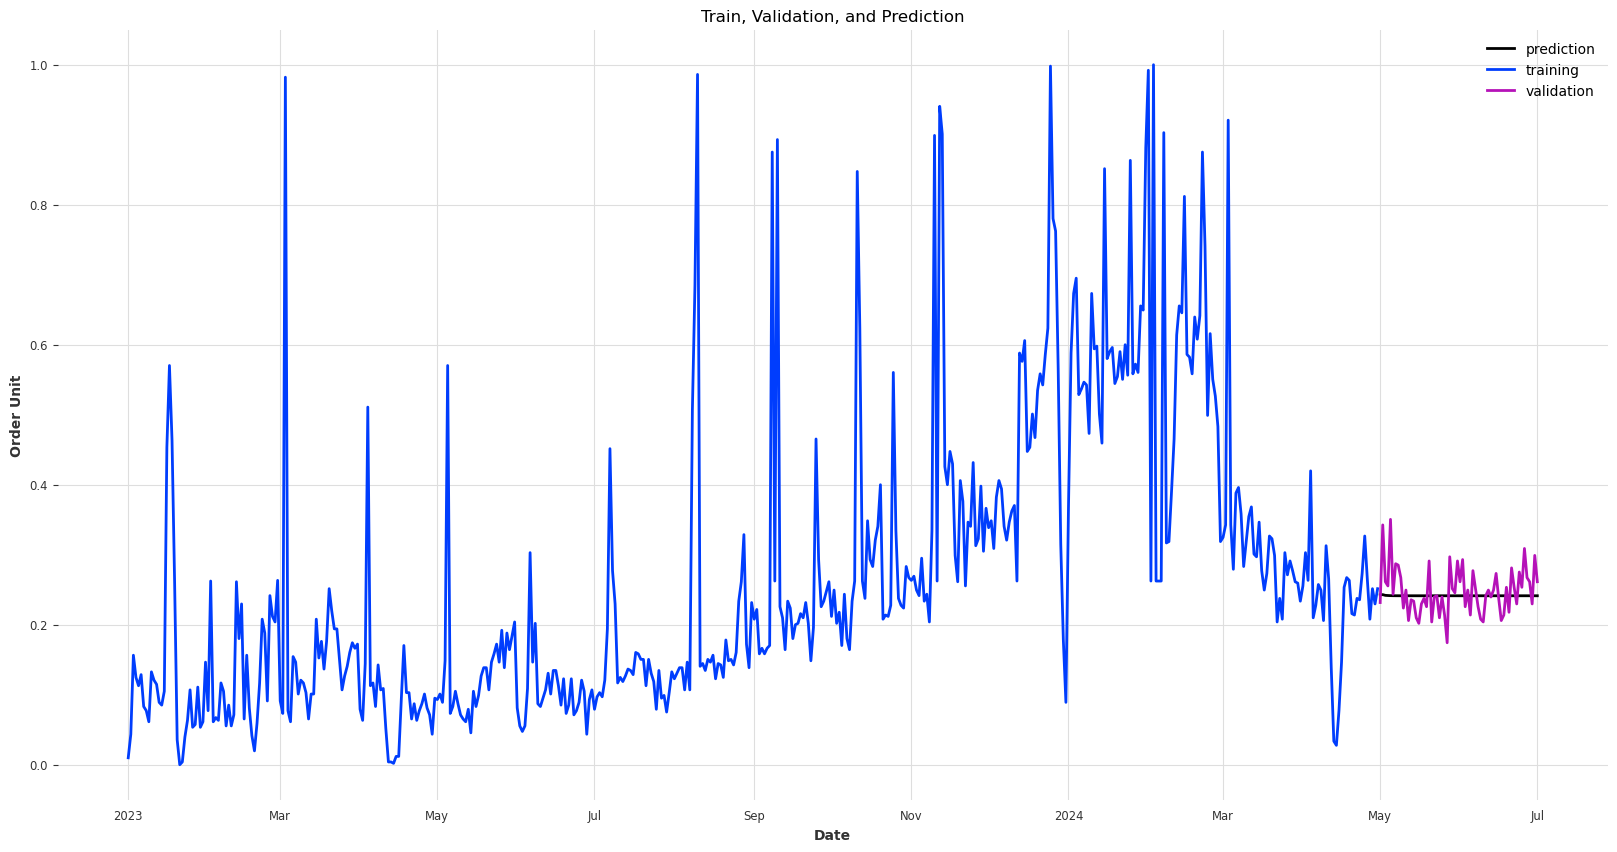

In [12]:
plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
##prediction
prediction.plot(label="prediction")
training.plot(label="training")
validation.plot(label="validation")

plt.legend()
plt.title('Train, Validation, and Prediction')
plt.xlabel('Date')
plt.ylabel('Order Unit')
plt.show()

In [14]:
# best_model = model
best_model.fit(series)

AutoARIMA(add_encoders=None, start_p=0, max_p=5, start_q=1)

In [16]:
forecast = best_model.predict(7)
forecast  = scaler.inverse_transform(forecast)
forecast = forecast.pd_dataframe().reset_index()
forecast.columns = ['Date', 'Total Order']
print(forecast.tail(7))

forecast.tail(7).to_csv('../forecast/Date1Jul_AutoARIMA.csv', index=False)

        Date  Total Order
0 2024-07-02   142.329529
1 2024-07-03   140.042218
2 2024-07-04   139.470005
3 2024-07-05   139.030551
4 2024-07-06   138.841150
5 2024-07-07   138.735409
6 2024-07-08   138.683369


In [17]:
best_model.save("../model/AutoARIMA_Model_totalOrder_1Jul67.pkl")